In [2]:
# libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, SelectKBest, SelectFromModel
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from utils import create_dataset_mri, cv


#CDE
#from cde.density_estimator import MixtureDensityNetwork
from tensorflow.python.keras.activations import tanh

#TF
import tensorflow as tf
import tensorflow.keras as keras

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# load the data
behavioral = pd.read_csv("data/Behavioral/AllData.csv")

# general info
shape = behavioral.shape  #2096, 7042
print(shape)

(2096, 7042)


In [5]:
list(filter(lambda x: "WISC" in x, behavioral.columns))

['WISC_complete',
 'WISC_incomplete_reason',
 'WISC_BD_Raw',
 'WISC_BD_Scaled',
 'WISC_Similarities_Raw',
 'WISC_Similarities_Scaled',
 'WISC_MR_Raw',
 'WISC_MR_Scaled',
 'WISC_DS_Raw',
 'WISC_DS_Scaled',
 'WISC_Coding_Raw',
 'WISC_Coding_Scaled',
 'WISC_Vocab_Raw',
 'WISC_Vocab_Scaled',
 'WISC_FW_Raw',
 'WISC_FW_Scaled',
 'WISC_VP_Raw',
 'WISC_VP_Scaled',
 'WISC_PS_Raw',
 'WISC_PS_Scaled',
 'WISC_SS_Raw',
 'WISC_SS_Scaled',
 'WISC_VSI_Sum',
 'WISC_VSI',
 'WISC_VSI_Percentile',
 'WISC_VCI_Sum',
 'WISC_VCI',
 'WISC_VCI_Percentile',
 'WISC_FRI_Sum',
 'WISC_FRI',
 'WISC_FRI_Percentile',
 'WISC_WMI_Sum',
 'WISC_WMI',
 'WISC_WMI_Percentile',
 'WISC_PSI_Sum',
 'WISC_PSI',
 'WISC_PSI_Percentile',
 'WISC_FSIQ_Sum',
 'WISC_FSIQ',
 'WISC_FSIQ_Percentile']

# Consider the dataset with all patients

(1146, 371)
(842, 371)


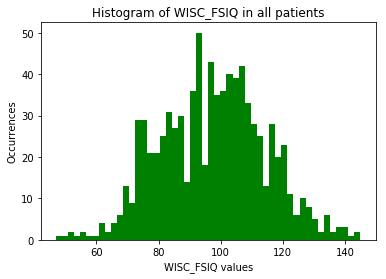

97.50118764845605
284.05047364887355


In [5]:
target = 'WISC_FSIQ'
disease = None
#disease = 'Attention-Deficit/Hyperactivity Disorder'
category = None
#category = 'DX_01_Sub' #Irrelevant since we are dropping the columns after

# Create the dataset dropping the diagnosis columns since we are not interested in them
data = create_dataset_mri(select_disease = disease, select_category = category, SCORE = target)
try:
    data.drop(columns=['DX_01_Cat'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01_Sub'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01'], inplace=True)
except:
    pass


# Drop the rows with some NaNs

print(data.shape)
data.dropna(axis=0, inplace=True)
print(data.shape)
column_names = data.columns[2:]


# Plot distribution of the target variable
plt.hist(data[target], 50, density=False, facecolor='g')
plt.xlabel('{} values'.format(target))
plt.ylabel('Occurrences')
plt.title('Histogram of {} in all patients'.format(target))
plt.show()

print(np.mean(data[target]))
print(np.var(data[target]))

In [6]:
# Define the labels and the features for regression
y = data[target]
X = data.drop([target, 'ID'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Store the dimensionality of the input
input_dim = X.shape[1]

## Define baseline

In [7]:
# Baseline: predict always the average
pred = np.full_like(np.zeros(len(y)), fill_value=np.mean(y))
mse = sum((pred - y)**2)/len(y)
print('Prediction mean: {}'.format(np.mean(y)))
print('MSE mean: {}'.format(mse))
r2 = r2_score(y_pred=(pred), y_true=y)
print('R2 mean: {}'.format(r2))

pred = np.full_like(np.zeros(len(y)), fill_value=np.median(y))
mse = sum((pred - y)**2)/len(y)
print('\nPrediction median: {}'.format(np.median(y)))
print('MSE median: {}'.format(mse))
r2 = r2_score(y_pred=pred, y_true=y)
print('R2 median: {}'.format(r2))

Prediction mean: 97.50118764845605
MSE mean: 284.0504736488733
R2 mean: 0.0

Prediction median: 97.5
MSE median: 284.05047505938245
R2 median: -4.9656978529100115e-09


**Note:** the r^2 is defined as 1 minus the ratio between the MSE of the model and the MSE of the sample mean, so it does not give us any additional info but it makes the comparison with the baseline more immediate.

### Simple Linear Regression

In [8]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('lr', LinearRegression())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 592.2573487421924
R squared: -1.1311892692629426


### Linear Regression + Tree-based feature selection

In [9]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('feat_select', SelectFromModel(ExtraTreesRegressor(100))),
  ('lr', LinearRegression())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 330.47819560313616
R squared: -0.1772700310734136


### SVR + Tree-based feature selection

In [12]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('feat_select', SelectFromModel(ExtraTreesRegressor(100))),
  ('regression', SVR())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 266.2007189337445
R squared: 0.05869768975026417


### Random Forest

In [13]:
search_space = [1,5,10,30,60,100,200]
mses_to_plot = []
for n_trees in search_space:

    pipe = Pipeline([ ('scaling', StandardScaler()),
      ('rf', RandomForestRegressor(n_estimators=n_trees, n_jobs=4))
    ])
    (mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

    mse = np.mean(mses)
    mses_to_plot.append(mse)
    print('MSE: {}'.format(mse))
    r2 = np.mean(r2s)
    print('R squared: {}'.format(r2))

MSE: 526.613432165319
R squared: -0.8766926366529124
MSE: 308.770765049416
R squared: -0.11395149078224781
MSE: 301.56511601527404
R squared: -0.07158182383428295
MSE: 276.6250777178796
R squared: 0.017152141185468095
MSE: 268.68266742163314
R squared: 0.020041634734319913
MSE: 270.7311899696766
R squared: 0.02785763418295506
MSE: 268.6880430651954
R squared: 0.04144324990555928


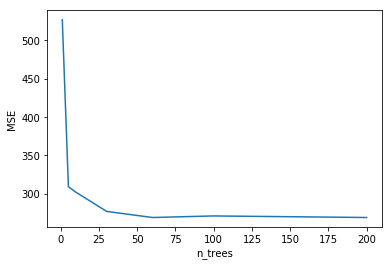

In [14]:
# Show relationship between size of the forest and error
plt.plot(search_space, mses_to_plot)
plt.ylabel('MSE')
plt.xlabel('n_trees')
plt.show()

### Neural Net

In [20]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(input_dim,)),
  tf.keras.layers.Dense(64, activation='tanh'),
  tf.keras.layers.Dense(64, activation='tanh'),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

def reset_weights(model):
    session = keras.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [19]:
def cv_for_nn(model, data, labels, n_splits = 5):
    '''
    model: must be a sklearn object with .fit and .predict methods
    data: the X matrix containing the features, can be a pd.DataFrame or a np object (array or matrix)
    labels: y, can be a pd.DataFrame or a np array
    n_splits: number of desired folds
    => returns array of mean suqared error calculated on each fold
    '''
    kf = KFold(n_splits=n_splits, shuffle=True)
    data = np.array(data).astype('float32')
    labels = np.array(labels).astype('float32')
    mses = []
    i = 1
    for train, test in kf.split(data):
        print("Split: {}".format(i), end="\r")
        X_train, X_test, y_train, y_test = data[train], data[test], labels[train], labels[test]
        
        reset_weights(model)
        
        model.fit(x=X_train, y=y_train, verbose=0, epochs=1000)
        mse = model.evaluate(x=X_test,  y=y_test, verbose=1)[0]
        
        pred = model.predict(x=X_test)
        
        mse2 = sum((pred.flatten()-y_test)**2)/len(y_test)
        
        print('MSE: {}'.format(mse))
        mses.append(mse)
        i = i+1
    return mses

res = cv_for_nn(model=model, data=X_scaled, labels=y, n_splits=5)
np.mean(res)

169/169 [==============================] - 0s 193us/sample - loss: 403.8488 - acc: 0.0000e+00
MSE: 403.8487723536745
169/169 [==============================] - 0s 30us/sample - loss: 378.9919 - acc: 0.0000e+00
MSE: 378.99191893628364
168/168 [==============================] - 0s 31us/sample - loss: 371.4829 - acc: 0.0000e+00
MSE: 371.48285493396577
168/168 [==============================] - 0s 29us/sample - loss: 451.7048 - acc: 0.0000e+00
MSE: 451.70480274018786
168/168 [==============================] - 0s 30us/sample - loss: 296.0667 - acc: 0.0000e+00
MSE: 296.0667245047433


380.4190146937711

### Conclusions
There seems to be almost no relationship between the MRI data and the results to the WISC test, if all patients are considered regardless the diagnosis.

# Consider only patients with ADHD

In [6]:
behavioral['DX_01_Cat'].value_counts()

Neurodevelopmental Disorders                                  1167
No Diagnosis Given: Incomplete Eval                            278
No Diagnosis Given                                             235
Anxiety Disorders                                              189
Depressive Disorders                                            94
Disruptive                                                      40
Trauma and Stressor Related Disorders                           35
Obsessive Compulsive and Related Disorders                      16
Elimination Disorders                                           11
Other Conditions That May Be a Focus of Clinical Attention       8
Bipolar and Related Disorders                                    6
Disruptive, Impulse Control and Conduct Disorders                5
Neurocognitive Disorders                                         3
Schizophrenia Spectrum and other Psychotic Disorders             3
Gender Dysphoria                                              

(576, 372)
(436, 372)


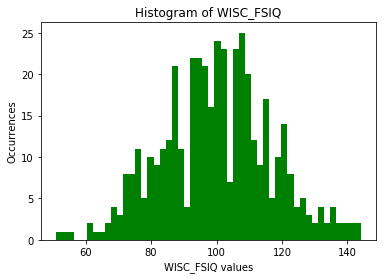

99.98853211009174
278.51592353337264


In [7]:
target = 'WISC_FSIQ'
disease = None
#disease = 'Attention-Deficit/Hyperactivity Disorder'
#disease = 'No Diagnosis Given'
category = None
#category = 'DX_01_Cat' 

# Create the dataset dropping the diagnosis columns since we are not interested in them
data = create_dataset_mri(select_disease = disease, select_category = category, SCORE = target, age_less_than=10)
try:
    data.drop(columns=['DX_01_Cat'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01_Sub'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01'], inplace=True)
except:
    pass


# Drop the rows with some NaNs

print(data.shape)
data.dropna(axis=0, inplace=True)
print(data.shape)
column_names = data.columns[2:]


plt.hist(data[target], 50, density=False, facecolor='g')
plt.xlabel('{} values'.format(target))
plt.ylabel('Occurrences')
plt.title('Histogram of {}'.format(target))
plt.show()


print(np.mean(data[target]))
print(np.var(data[target]))

In [8]:
# Define the labels and the features for regression
y = data[target]
X = data.drop([target, 'ID'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Store the dimensionality of the input
input_dim = X.shape[1]

## Define baseline

In [10]:
# Baseline: predict always the average
pred = np.full_like(np.zeros(len(y)), fill_value=np.mean(y))
mse = sum((pred - y)**2)/len(y)
print('Prediction mean: {}'.format(np.mean(y)))
print('MSE mean: {}'.format(mse))
r2 = r2_score(y_pred=(pred), y_true=y)
print('R2 mean: {}'.format(r2))

pred = np.full_like(np.zeros(len(y)), fill_value=np.median(y))
mse = sum((pred - y)**2)/len(y)
print('\nPrediction median: {}'.format(np.median(y)))
print('MSE median: {}'.format(mse))
r2 = r2_score(y_pred=pred, y_true=y)
print('R2 median: {}'.format(r2))

Prediction mean: 99.98853211009174
MSE mean: 278.51592353337236
R2 mean: 0.0

Prediction median: 101.0
MSE median: 279.5389908256881
R2 median: -0.003673281151527652


**Note:** the r^2 is defined as 1 minus the ratio between the MSE of the model and the MSE of the sample mean, so it does not give us any additional info but it makes the comparison with the baseline more immediate.

### Simple Linear Regression

In [11]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('lr', LinearRegression())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 11457.322565334825
R squared: -42.17434822862076


### Linear Regression + Tree-based feature selection

In [12]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('feat_select', SelectFromModel(ExtraTreesRegressor(100))),
  ('lr', LinearRegression())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 368.39472952507276
R squared: -0.35255311876158824


### SVR + Tree-based feature selection

In [13]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('feat_select', SelectFromModel(ExtraTreesRegressor(100))),
  ('regression', SVR())
])
(mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

mse = np.mean(mses)
print('MSE: {}'.format(mse))
r2 = np.mean(r2s)
print('R squared: {}'.format(r2))

MSE: 263.3343973843566
R squared: 0.04133827751923516


### Random Forest

In [14]:
search_space = [1,5,10,30,60,100]
mses_to_plot = []
for n_trees in search_space:

    pipe = Pipeline([ ('scaling', StandardScaler()),
      ('rf', RandomForestRegressor(n_estimators=n_trees, n_jobs=4))
    ])
    (mses, r2s) = cv(model=pipe, data=X, labels=y, n_splits=8, want_r2=True)

    mse = np.mean(mses)
    mses_to_plot.append(mse)
    print('MSE: {}'.format(mse))
    r2 = np.mean(r2s)
    print('R squared: {}'.format(r2))

MSE: 592.5629208754209
R squared: -1.2006330696656262
MSE: 318.5175269360269
R squared: -0.1681065820106879
MSE: 300.3871094276095
R squared: -0.09472760945543258
MSE: 264.2147620183314
R squared: 0.034592947915886546
MSE: 261.8459856200898
R squared: 0.04726557199248474
MSE: 262.5309991161616
R squared: 0.04634662656047776


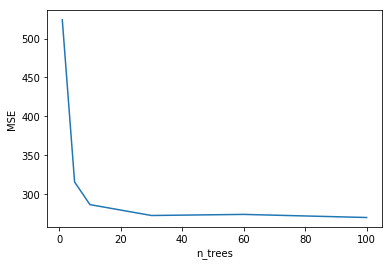

In [44]:
# Show relationship between size of the forest and error
plt.plot(search_space, mses_to_plot)
plt.ylabel('MSE')
plt.xlabel('n_trees')
plt.show()

### Conclusions
Even if we consider the subset of patients who were diagnosed ADHD, there still seems to be almost no relationship between the MRI data and the results to the WISC test to measure the full scale IQ.